In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils


C:\Users\dynamic_h\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.2.4


In [4]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

In [5]:

# Describe the data
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.0    -0.3
13       33  Jogging  49107312332000    -6.1     6.9    -8.2
14       33  Jogging  49107422348000     5.8    18.0     8.5
15       33  Jogging  49107522293000     6.3     3.0     2.9
16       33  Jogging  49107632339000    -1.6     8.3    -1.5
17       33  Jogging  49107742355000     3.5    13.6     9.4
18       33  Jogging  49107852340000    -2.0    -5.7   -10.2
19       33  Jogging  49107962326000     2.8    10.3    -9.7

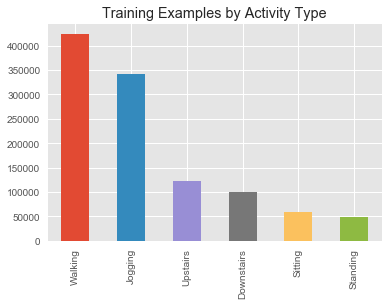

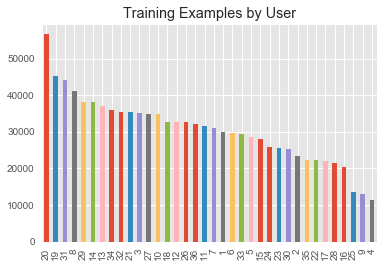

In [6]:

# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

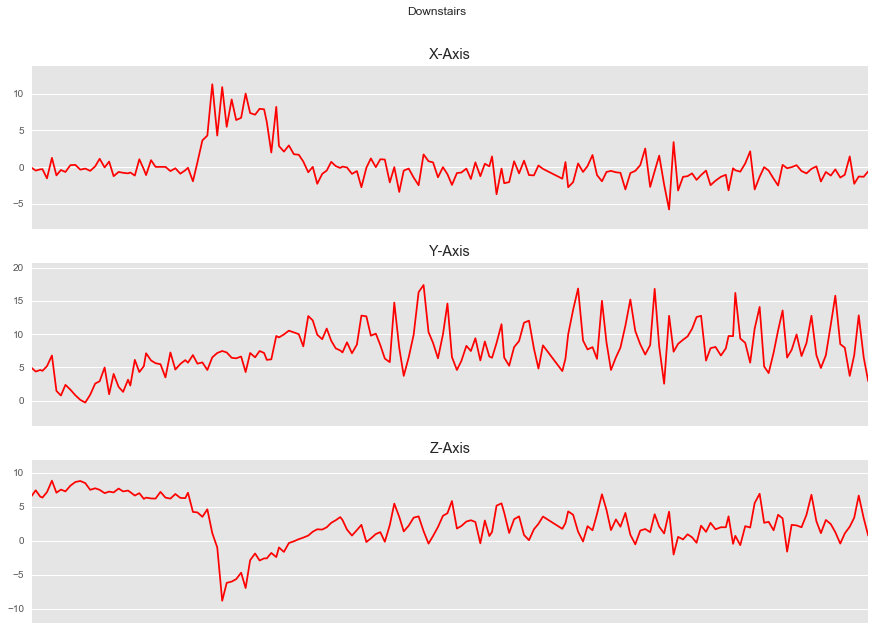

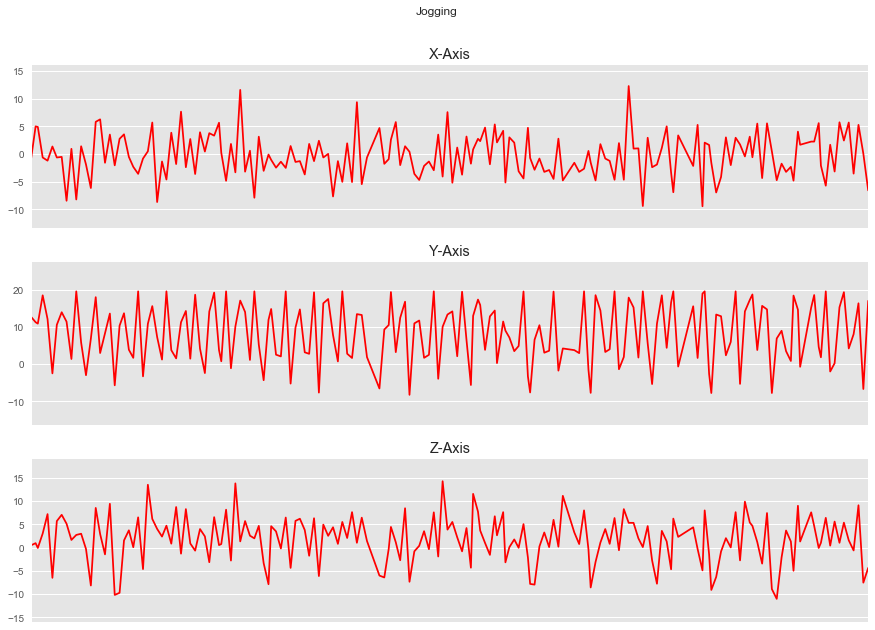

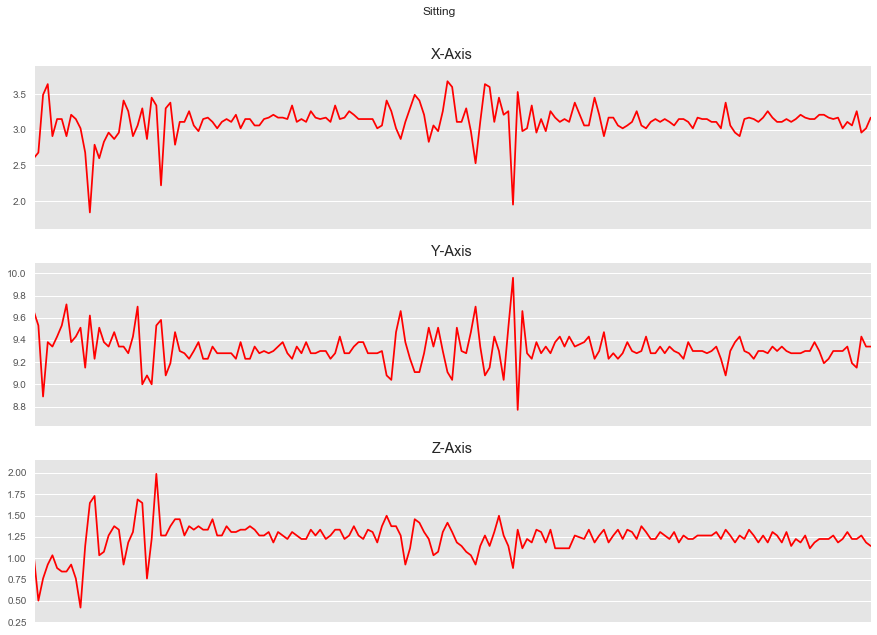

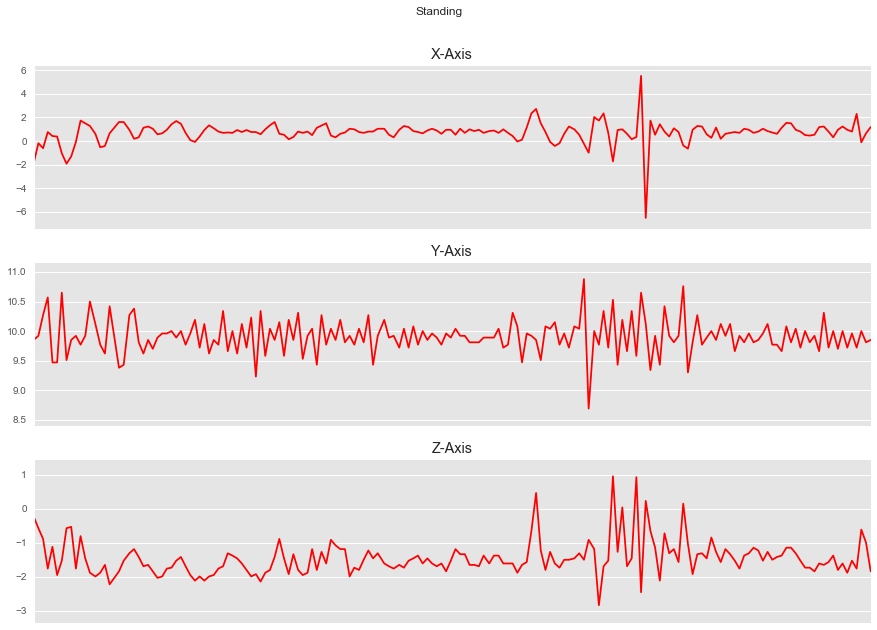

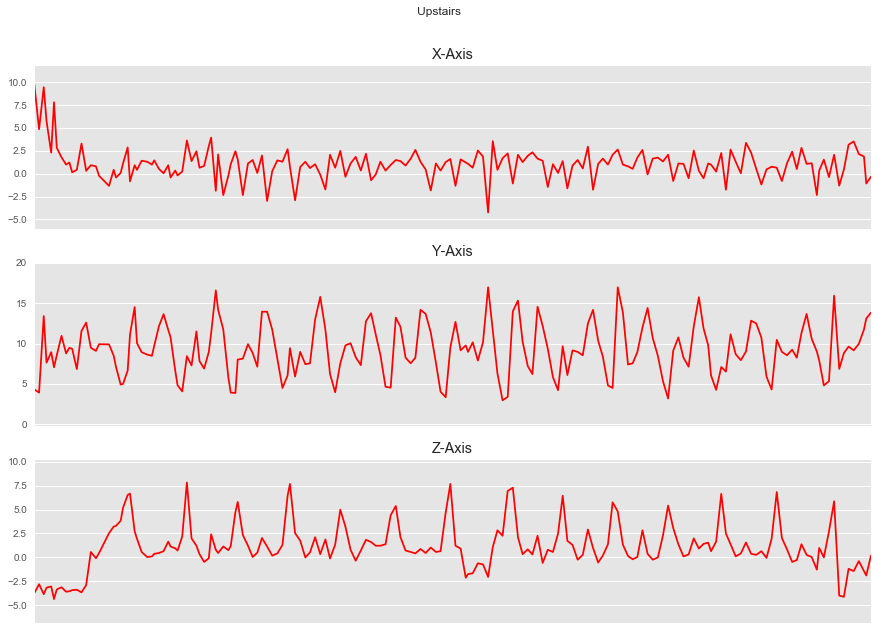

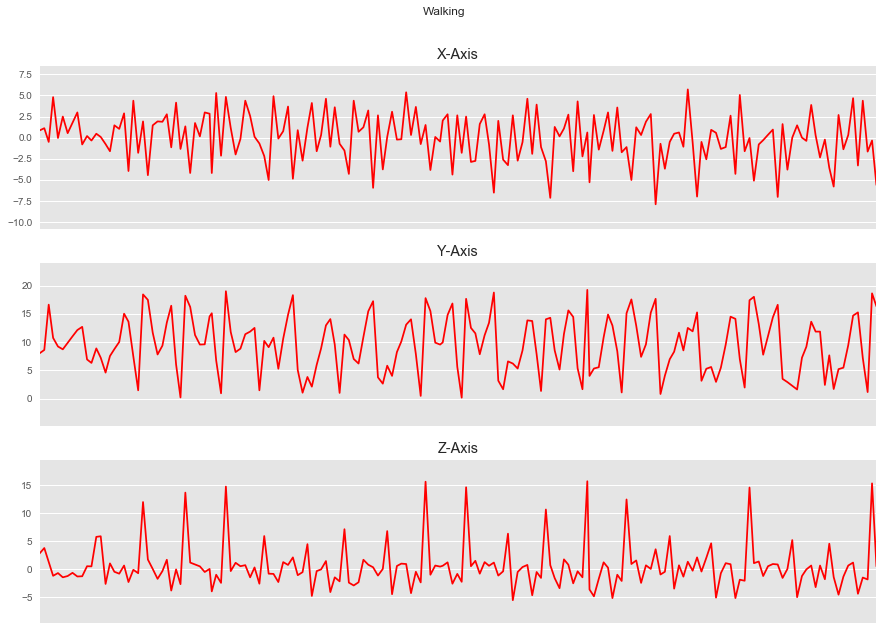

In [7]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [8]:

# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [9]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [10]:

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [11]:

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [12]:

print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [13]:

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [14]:

input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


In [15]:

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [16]:

y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [17]:

model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


In [18]:

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 12s 729us/step - loss: 1.0387 - acc: 0.6562 - val_loss: 0.7266 - val_acc: 0.8038
Epoch 2/50
16694/16694 [==============================] - 11s 679us/step - loss: 0.5846 - acc: 0.7908 - val_loss: 0.6631 - val_acc: 0.8103
Epoch 3/50
16694/16694 [==============================] - 11s 630us/step - loss: 0.5195 - acc: 0.8100 - val_loss: 0.6518 - val_acc: 0.8136
Epoch 4/50
16694/16694 [==============================] - 11s 632us/step - loss: 0.4977 - acc: 0.8195 - val_loss: 0.6751 - val_acc: 0.7971
Epoch 5/50
16694/16694 [==============================] - 10s 626us/step - loss: 0.4696 - acc: 0.8294 - val_loss: 0.6525 - val_acc: 0.7995
Epoch 6/50
16694/16694 [==============================] - 11s 630us/step - loss: 0.4517 - acc: 0.8380 - val_loss: 0.6687 - val_acc: 0.7923
Epoch 7/50
16694/16694 [==============================] - 11s 639us/step - loss: 0.4367 - acc: 0.8418 - val_loss: 0.6

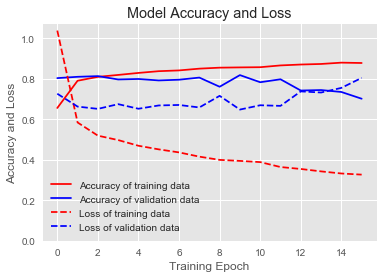

             precision    recall  f1-score   support

        0.0       0.46      0.60      0.52      1864
        1.0       0.95      0.99      0.97      6567
        2.0       0.98      0.99      0.98      1050
        3.0       0.99      0.98      0.98       833
        4.0       0.63      0.52      0.57      2342
        5.0       0.88      0.84      0.86      8212

avg / total       0.85      0.84      0.84     20868



In [19]:

plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [20]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

6584/6584 [==============================] - 1s 176us/step

Accuracy on test data: 0.71

Loss on test data: 1.34


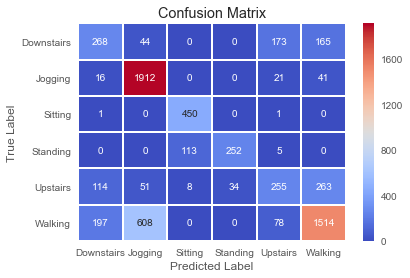

             precision    recall  f1-score   support

          0       0.45      0.41      0.43       650
          1       0.73      0.96      0.83      1990
          2       0.79      1.00      0.88       452
          3       0.88      0.68      0.77       370
          4       0.48      0.35      0.41       725
          5       0.76      0.63      0.69      2397

avg / total       0.70      0.71      0.69      6584



In [21]:

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))